# Modelling and Evaluation

## Objectives

- Answer Business requirement 2:
    - The client is interested to tell whether a give image of a cherry leaf is healthy or has powdery mildew.

## Inputs

- inputs/cherry_leaves/cherry-leaves/train
- inputs/cherry_leaves/cherry-leaves/test
- inputs/cherry_leaves/cherry-leaves/validation

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

# Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Set input directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

Create folders to store results

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Image Labels: {labels}"
)

Image Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




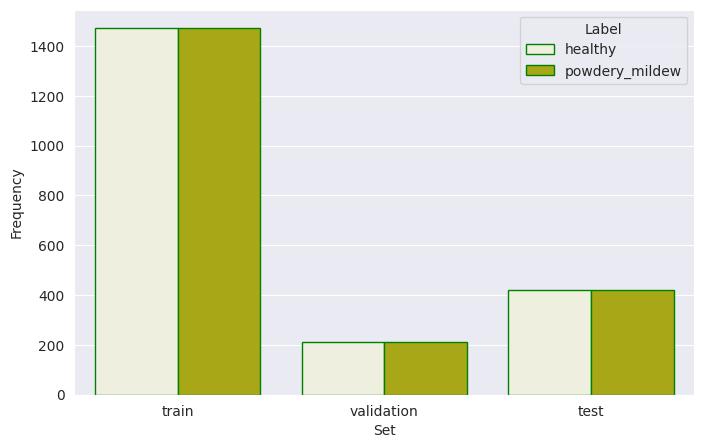

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
# create bar plot
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', color='y', edgecolor='g')
# save figure to output directory
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

- Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

#### Augment training image dataset

In [12]:
# Set batch size
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


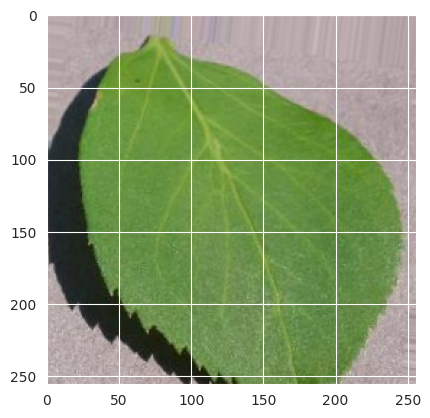

(20, 256, 256, 3)


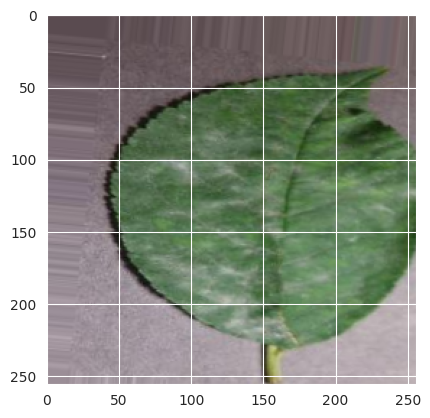

(20, 256, 256, 3)


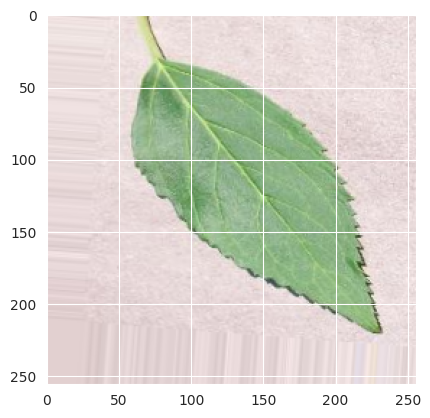

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation image

(20, 256, 256, 3)


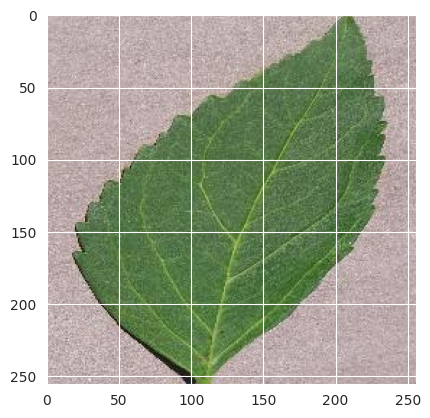

(20, 256, 256, 3)


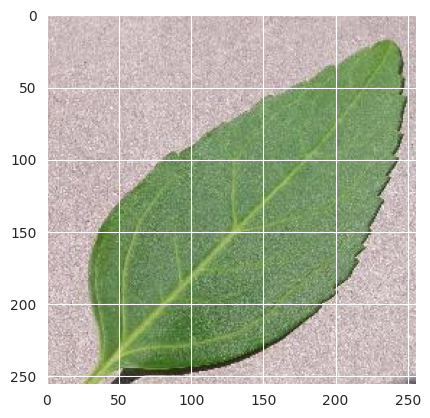

(20, 256, 256, 3)


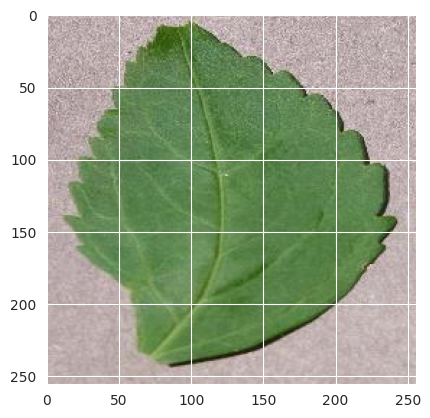

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   
    plt.imshow(img[0])
    plt.show()

## Plot augmented test image

(20, 256, 256, 3)


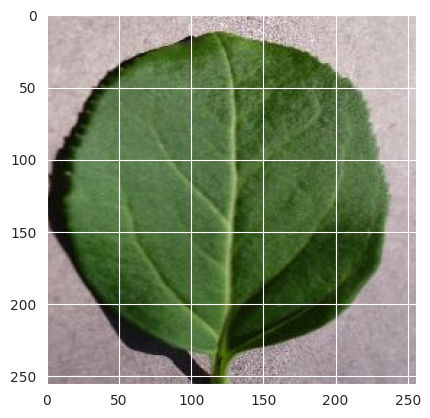

(20, 256, 256, 3)


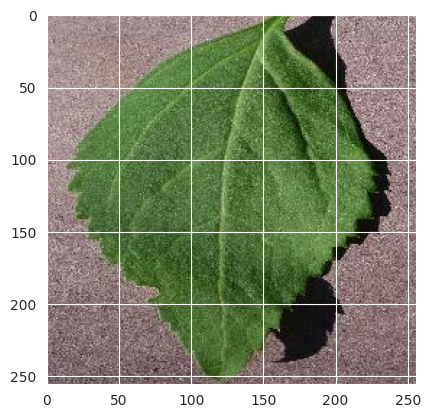

(20, 256, 256, 3)


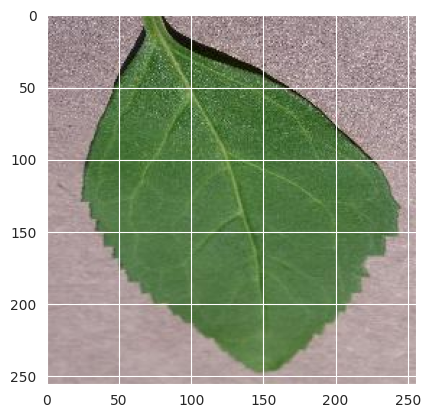

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

- Import packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### **Model**

- CNN model is used for image processing and designed for binary image classification.
- Sequential model arranges a sequence of layers in  neural network.
- Model has 3 convolutional layers:
    - 1st convolutional layer has 16 filters, size 3x3, relu activation function and and max pooling layer.
    - 2nd convolutional layer has 32 filters, size 3x3, relu activation function and and max pooling layer.
    - 3rd convolutional layer has 32 filters, size 3x3, relu activation function and and max pooling layer.
- Dense layer has 64 neurons.
- Dropout layer and earlystopping is used to reduce the chance of overfitting the neural network.
- The output layer has one neuron with a sigmoid as the activation function.
- The loss function used is binary_crossentropy because it is a binary classification.
- The optimizer used is adam.

In [26]:
def create_tf_model():
    """
    Create a sequential model for binary image classification.
    """
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape,
              activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape,
              activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape,
              activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

    return model

#### Model summary

In [27]:
create_tf_model().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28800)            

#### Early stopping

- Add early stopping to prevent model from overfitting 

In [31]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [32]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 [==============================] - 154s 1s/step - loss: 0.3736 - accuracy: 0.8075 - val_loss: 0.0192 - val_accuracy: 0.9952
Epoch 2/25
147/147 [==============================] - 154s 1s/step - loss: 0.1112 - accuracy: 0.9631 - val_loss: 0.0162 - val_accuracy: 0.9976
Epoch 3/25
147/147 [==============================] - 153s 1s/step - loss: 0.0517 - accuracy: 0.9822 - val_loss: 0.0041 - val_accuracy: 0.9976
Epoch 4/25
147/147 [==============================] - 155s 1s/step - loss: 0.0377 - accuracy: 0.9897 - val_loss: 0.0129 - val_accuracy: 0.9952
Epoch 5/25
147/147 [==============================] - 155s 1s/step - loss: 0.0421 - accuracy: 0.9884 - val_loss: 0.0119 - val_accuracy: 0.9976
Epoch 6/25
147/147 [==============================] - 154s 1s/step - loss: 0.0252 - accuracy: 0.9932 - val_loss: 0.0029 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 154s 1s/step - loss: 0.0325 - accuracy: 0.9867 - val_loss: 0.0010 - val_accuracy: 1.0000

### Save Model

In [34]:
model.save('outputs/v1/mildew_detection_model.h5')

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.